# Workflows

In [2]:
from cosim.flow import Flow
#import networkx as nx

### create a new workflow

In [3]:
# a diction of tasks and their input-outputs
info = {
    "tA": {"inputs": ("x1",),          "outputs": ("y1", "y2",), }, 
    "tB": {"inputs": ("y1",),          "outputs": ("z1",),       },
    "tC": {"inputs": ("y2",),          "outputs": ("z2",),       },
    "tD": {"inputs": ("z2", "z1",),    "outputs": ("out",),      }, 
}

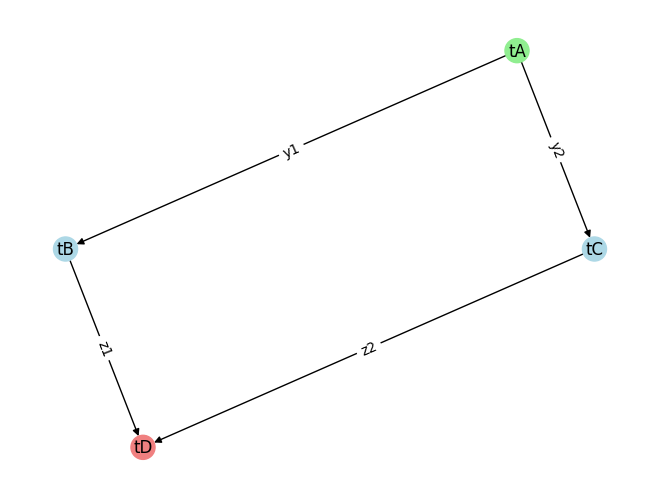

In [4]:
flow = Flow(**info)
flow.render() # 'multipartite_layout'

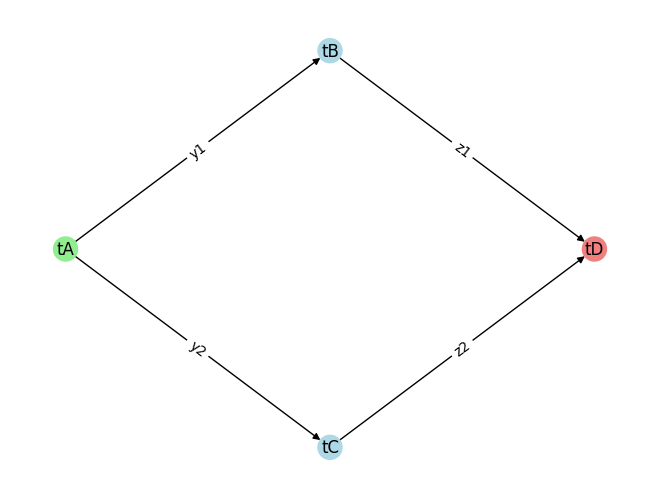

In [5]:
flow.render('multipartite_layout')

In [6]:
flow.LAYERS

(['tA'], ['tB', 'tC'], ['tD'])

In [7]:
flow.ENTRY, flow.EXIT, flow.NODES

('tA', 'tD', ['tA', 'tB', 'tC', 'tD'])

In [8]:
flow.INFO

{'tA': {'inputs': ('x1',), 'outputs': ('y1', 'y2')},
 'tB': {'inputs': ('y1',), 'outputs': ('z1',)},
 'tC': {'inputs': ('y2',), 'outputs': ('z2',)},
 'tD': {'inputs': ('z2', 'z1'), 'outputs': ('out',)}}

In [9]:
for n in flow.nodes: print(n, flow.nodes[n])
for n in flow.nodes: print(f' {list(flow.predecessors(n))} --> {n} --> {list(flow.successors(n))}')
for e in flow.edges: print(e, flow.edges[e])

tA {'inputs': ('x1',), 'outputs': ('y1', 'y2'), 'subset': 0}
tB {'inputs': ('y1',), 'outputs': ('z1',), 'subset': 1}
tC {'inputs': ('y2',), 'outputs': ('z2',), 'subset': 1}
tD {'inputs': ('z2', 'z1'), 'outputs': ('out',), 'subset': 2}
 [] --> tA --> ['tB', 'tC']
 ['tA'] --> tB --> ['tD']
 ['tA'] --> tC --> ['tD']
 ['tB', 'tC'] --> tD --> []
('tA', 'tB') {'data': 'y1'}
('tA', 'tC') {'data': 'y2'}
('tB', 'tD') {'data': 'z1'}
('tC', 'tD') {'data': 'z2'}


# Infra

In [10]:
import json
with open('__infra__.json', 'r') as j: infra = json.load(j)
actions = list(infra.keys())
print(actions)
infra

['I', 'E', 'C']


{'I': {'host': '127.0.0.1',
  'nport': '9800',
  'dport': '9801',
  'urlscheme': 'http://',
  'xy': [0.0, 0.0]},
 'E': {'host': '127.0.0.1',
  'nport': '9810',
  'dport': '9811',
  'urlscheme': 'http://',
  'xy': [0.0, 0.0]},
 'C': {'host': '127.0.0.1',
  'nport': '9820',
  'dport': '9821',
  'urlscheme': 'http://',
  'xy': [0.0, 0.0]}}

# Offload `flow` on `infra` using `decision`

In [11]:
decision = dict(
    tA = actions[0], tB = actions[1], tC = actions[2], tD = actions[2]
)

decision

{'tA': 'I', 'tB': 'E', 'tC': 'C', 'tD': 'C'}

In [12]:

def now(year:bool=True, month:bool=True, day:bool=True, 
        hour:bool=True, minute:bool=True, second:bool=True, mirco:bool=True, 
        start:str='', sep:str='', end:str='') -> str:
    form = []
    if year:    form.append("%Y")
    if month:   form.append("%m")
    if day:     form.append("%d")
    if hour:    form.append("%H")
    if minute:  form.append("%M")
    if second:  form.append("%S")
    if mirco:   form.append("%f")
    assert (form), 'format should not be empty!'
    import datetime
    return (start + datetime.datetime.strftime(datetime.datetime.now(), sep.join(form)) + end)

In [13]:
fid = now(start='UE28893_')
for n in flow.NODES: 
    flow.INFO[n]['name'] = n
    flow.INFO[n]['offl'] = decision[n]
    flow.INFO[n]['uid'] = f'{fid}_{n}'
    flow.INFO[n]['fid'] = f'{fid}'
    #for o in flow.INFO[n]['outputs']:
    #flow.INFO[n]['outsend'] = {flow.edges[n]['data']:n[-1] for n in flow.out_edges(n)}
    flow.INFO[n]['outsend'] = {
        flow.edges[n]['data'] :  (  
            n[-1], decision[n[-1]], 
            f"{infra[decision[n[-1]]]['urlscheme']}{infra[decision[n[-1]]]['host'] }",
            infra[decision[n[-1]]]['nport'], infra[decision[n[-1]]]['dport']
                  )  for n in flow.out_edges(n)}

for o in flow.INFO[flow.EXIT]['outputs']:
    flow.INFO[flow.EXIT]['outsend'][o] = ('', decision[flow.ENTRY],  
            f"{infra[decision[flow.ENTRY]]['urlscheme']}{infra[decision[flow.ENTRY]]['host'] }",
            infra[decision[flow.ENTRY]]['nport'], infra[decision[flow.ENTRY]]['dport']
                  )

flow.INFO

{'tA': {'inputs': ('x1',),
  'outputs': ('y1', 'y2'),
  'name': 'tA',
  'offl': 'I',
  'uid': 'UE28893_20260102085950759031_tA',
  'fid': 'UE28893_20260102085950759031',
  'outsend': {'y1': ('tB', 'E', 'http://127.0.0.1', '9810', '9811'),
   'y2': ('tC', 'C', 'http://127.0.0.1', '9820', '9821')}},
 'tB': {'inputs': ('y1',),
  'outputs': ('z1',),
  'name': 'tB',
  'offl': 'E',
  'uid': 'UE28893_20260102085950759031_tB',
  'fid': 'UE28893_20260102085950759031',
  'outsend': {'z1': ('tD', 'C', 'http://127.0.0.1', '9820', '9821')}},
 'tC': {'inputs': ('y2',),
  'outputs': ('z2',),
  'name': 'tC',
  'offl': 'C',
  'uid': 'UE28893_20260102085950759031_tC',
  'fid': 'UE28893_20260102085950759031',
  'outsend': {'z2': ('tD', 'C', 'http://127.0.0.1', '9820', '9821')}},
 'tD': {'inputs': ('z2', 'z1'),
  'outputs': ('out',),
  'name': 'tD',
  'offl': 'C',
  'uid': 'UE28893_20260102085950759031_tD',
  'fid': 'UE28893_20260102085950759031',
  'outsend': {'out': ('', 'I', 'http://127.0.0.1', '9800',

# offload now

In [14]:
import requests

In [15]:

# offload tA first
tK = 'tA'
response = requests.post(
    url=f"{infra[decision[tK]]['urlscheme']}{infra[decision[tK]]['host']}:{infra[decision[tK]]['nport']}/add",
    json=flow.INFO[tK]
    )
response.__dict__

{'_content': b'{"received":"UE28893_20260102085950759031_tA"}\n',
 '_content_consumed': True,
 '_next': None,
 'status_code': 200,
 'headers': {'Content-Length': '47', 'Content-Type': 'application/json', 'Date': 'Fri, 02 Jan 2026 03:29:50 GMT', 'Server': 'waitress'},
 'raw': <urllib3.response.HTTPResponse at 0x7f0a06494940>,
 'url': 'http://127.0.0.1:9800/add',
 'encoding': 'utf-8',
 'history': [],
 'reason': 'OK',
 'cookies': <RequestsCookieJar[]>,
 'elapsed': datetime.timedelta(microseconds=4483),
 'request': <PreparedRequest [POST]>,
 'connection': <requests.adapters.HTTPAdapter at 0x7f0a086ceb40>}

In [16]:

# offload tB first
tK = 'tB'
response = requests.post(
    url=f"{infra[decision[tK]]['urlscheme']}{infra[decision[tK]]['host']}:{infra[decision[tK]]['nport']}/add",
    json=flow.INFO[tK]
    )
response.__dict__

{'_content': b'{"received":"UE28893_20260102085950759031_tB"}\n',
 '_content_consumed': True,
 '_next': None,
 'status_code': 200,
 'headers': {'Content-Length': '47', 'Content-Type': 'application/json', 'Date': 'Fri, 02 Jan 2026 03:29:50 GMT', 'Server': 'waitress'},
 'raw': <urllib3.response.HTTPResponse at 0x7f0a4949db10>,
 'url': 'http://127.0.0.1:9810/add',
 'encoding': 'utf-8',
 'history': [],
 'reason': 'OK',
 'cookies': <RequestsCookieJar[]>,
 'elapsed': datetime.timedelta(microseconds=3996),
 'request': <PreparedRequest [POST]>,
 'connection': <requests.adapters.HTTPAdapter at 0x7f0a086ba3c0>}

In [17]:

# offload tC first
tK = 'tC'
response = requests.post(
    url=f"{infra[decision[tK]]['urlscheme']}{infra[decision[tK]]['host']}:{infra[decision[tK]]['nport']}/add",
    json=flow.INFO[tK]
    )
response.__dict__

{'_content': b'{"received":"UE28893_20260102085950759031_tC"}\n',
 '_content_consumed': True,
 '_next': None,
 'status_code': 200,
 'headers': {'Content-Length': '47', 'Content-Type': 'application/json', 'Date': 'Fri, 02 Jan 2026 03:29:50 GMT', 'Server': 'waitress'},
 'raw': <urllib3.response.HTTPResponse at 0x7f0a0867f190>,
 'url': 'http://127.0.0.1:9820/add',
 'encoding': 'utf-8',
 'history': [],
 'reason': 'OK',
 'cookies': <RequestsCookieJar[]>,
 'elapsed': datetime.timedelta(microseconds=3008),
 'request': <PreparedRequest [POST]>,
 'connection': <requests.adapters.HTTPAdapter at 0x7f0a06313b00>}

In [18]:

# offload tD first
tK = 'tD'
response = requests.post(
    url=f"{infra[decision[tK]]['urlscheme']}{infra[decision[tK]]['host']}:{infra[decision[tK]]['nport']}/add",
    json=flow.INFO[tK]
    )
response.__dict__

{'_content': b'{"received":"UE28893_20260102085950759031_tD"}\n',
 '_content_consumed': True,
 '_next': None,
 'status_code': 200,
 'headers': {'Content-Length': '47', 'Content-Type': 'application/json', 'Date': 'Fri, 02 Jan 2026 03:29:50 GMT', 'Server': 'waitress'},
 'raw': <urllib3.response.HTTPResponse at 0x7f0a0864ee90>,
 'url': 'http://127.0.0.1:9820/add',
 'encoding': 'utf-8',
 'history': [],
 'reason': 'OK',
 'cookies': <RequestsCookieJar[]>,
 'elapsed': datetime.timedelta(microseconds=2550),
 'request': <PreparedRequest [POST]>,
 'connection': <requests.adapters.HTTPAdapter at 0x7f0a063546e0>}

In [19]:
# make_inputs_at = '/home/ava/Server/Code/GitHub/cosim/__infra__/I/data/x1'
# import pickle
# with open(make_inputs_at, 'wb') as f: pickle.dump(12, f)

import pickle
with open('__input__.pack', 'wb') as f: pickle.dump(12, f)

In [20]:
begin_node = f"{infra[decision[flow.ENTRY]]['urlscheme']}{infra[decision[flow.ENTRY]]['host']}:{infra[decision[flow.ENTRY]]['nport']}"
inital_node = f"{infra[decision[flow.ENTRY]]['urlscheme']}{infra[decision[flow.ENTRY]]['host']}:{infra[decision[flow.ENTRY]]['dport']}"
initial_input_name = f"{flow.INFO[flow.ENTRY]['uid']}_{flow.INFO[flow.ENTRY]['inputs'][0]}"
initial_input_url = f"{inital_node}/data/{initial_input_name}"
begin_node,inital_node,initial_input_name, initial_input_url

('http://127.0.0.1:9800',
 'http://127.0.0.1:9801',
 'UE28893_20260102085950759031_tA_x1',
 'http://127.0.0.1:9801/data/UE28893_20260102085950759031_tA_x1')

In [21]:
with open('__input__.pack', 'rb') as f: response = requests.post(url=initial_input_url, files={initial_input_name:f})
response.__dict__

{'_content': b'1',
 '_content_consumed': True,
 '_next': None,
 'status_code': 200,
 'headers': {'Content-Length': '1', 'Content-Type': 'text/html; charset=utf-8', 'Date': 'Fri, 02 Jan 2026 03:29:50 GMT', 'Server': 'waitress'},
 'raw': <urllib3.response.HTTPResponse at 0x7f0a06355150>,
 'url': 'http://127.0.0.1:9801/data/UE28893_20260102085950759031_tA_x1',
 'encoding': 'utf-8',
 'history': [],
 'reason': 'OK',
 'cookies': <RequestsCookieJar[]>,
 'elapsed': datetime.timedelta(microseconds=5856),
 'request': <PreparedRequest [POST]>,
 'connection': <requests.adapters.HTTPAdapter at 0x7f0a063543b0>}

In [22]:

response = requests.post(
    url=f"{begin_node}/note",
    json={
        'uid': flow.INFO[flow.ENTRY]['uid'],
        'outputs': {
            'x1': initial_input_name,
        },
    }
)
response.__dict__

{'_content': b'{"data":["x1"],"received":"UE28893_20260102085950759031_tA"}\n',
 '_content_consumed': True,
 '_next': None,
 'status_code': 200,
 'headers': {'Content-Length': '61', 'Content-Type': 'application/json', 'Date': 'Fri, 02 Jan 2026 03:29:50 GMT', 'Server': 'waitress'},
 'raw': <urllib3.response.HTTPResponse at 0x7f0a063136d0>,
 'url': 'http://127.0.0.1:9800/note',
 'encoding': 'utf-8',
 'history': [],
 'reason': 'OK',
 'cookies': <RequestsCookieJar[]>,
 'elapsed': datetime.timedelta(microseconds=4114),
 'request': <PreparedRequest [POST]>,
 'connection': <requests.adapters.HTTPAdapter at 0x7f0a06355ac0>}

# ... wait for rsponse

In [23]:
raise ValueError

ValueError: 

In [24]:
inital_node = f"{infra[decision[flow.ENTRY]]['urlscheme']}{infra[decision[flow.ENTRY]]['host']}:{infra[decision[flow.ENTRY]]['dport']}"
final_input_name = f"{flow.INFO[flow.EXIT]['uid']}_{flow.INFO[flow.EXIT]['outputs'][0]}"
final_input_url = f"{inital_node}/data/{final_input_name}"
inital_node,final_input_name, final_input_url

('http://127.0.0.1:9801',
 'UE28893_20260102085950759031_tD_out',
 'http://127.0.0.1:9801/data/UE28893_20260102085950759031_tD_out')

In [25]:
response = requests.get(url=final_input_url,)
response

<Response [200]>

In [26]:

import os, pickle
with open('__output__.pack', 'wb') as p: p.write(response._content)
with open('__output__.pack', 'rb') as p: out = pickle.load(p)
print(type(out), out)

<class 'int'> 300


# end